In [10]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import Precision
from keras.metrics import Recall
from keras import applications
from keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
BATCH_SIZE = 50
IMG_SIZE = (224, 224)
IMG_SIZE_CH = (224, 224, 3)
EPOCHS = 100
class_weight = {0: 1.94, 1: 0.67}

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
train_datagen = ImageDataGenerator(rescale = 1./255,          # 픽셀값 스케일 조정
                                   validation_split = 0.2,
                                   rotation_range = 5,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.05,
                                   horizontal_flip = True,
                                   brightness_range = (0.95,1.05),
                                   fill_mode = 'nearest')    # augumentation은 좌우대칭만 적용


# 검증 및 테스트 이미지는 augmentation을 적용하지 않습니다. 모델 성능을 평가할 때에는 이미지 원본을 사용합니다.
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/train',  # this is the target directory
        target_size=IMG_SIZE,  # 모든 이미지의 크기가 IMG_SIZE로 조정됩니다.
        batch_size=BATCH_SIZE,
        class_mode='binary',  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.
        subset ='training')

val_generator = val_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


---

# 기본 모델

from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=IMG_SIZE_CH, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import Precision
from keras.metrics import Recall

model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

history = model.fit(
        train_generator,
        steps_per_epoch=4695 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=1)

loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

---

# VGG16 - Flatten

In [32]:
from keras import applications

VGG16_MODEL = applications.VGG16(input_shape = IMG_SIZE_CH, 
                           include_top=False, 
                           weights='imagenet') 
# 사전훈련된 가중치를 이용해 기본 모델을 인스턴스화

VGG16_MODEL.trainable=False                   # 기본 모델을 동결

model = Sequential()
model.add(VGG16_MODEL)
model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

history = model.fit(
        train_generator,
        steps_per_epoch=4695 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=1)

loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

---

# VGG16 - GlobalAveragePooling2D

In [33]:
from keras.layers import GlobalAveragePooling2D

model = Sequential()
model.add(VGG16_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.7))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

In [34]:
history = model.fit(
        train_generator,
        steps_per_epoch=4173 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weight)

Epoch 1/100
83/83 [==============================] - 100s 1s/step - loss: 0.6338 - accuracy: 0.6318 - precision: 0.8306 - recall: 0.6292 - val_loss: 0.4364 - val_accuracy: 0.8341 - val_precision: 0.9951 - val_recall: 0.7806
Epoch 2/100
83/83 [==============================] - 96s 1s/step - loss: 0.3881 - accuracy: 0.8638 - precision: 0.9573 - recall: 0.8542 - val_loss: 0.3097 - val_accuracy: 0.8744 - val_precision: 0.9864 - val_recall: 0.8426
Epoch 3/100
83/83 [==============================] - 96s 1s/step - loss: 0.3042 - accuracy: 0.8815 - precision: 0.9658 - recall: 0.8725 - val_loss: 0.3063 - val_accuracy: 0.8696 - val_precision: 0.9953 - val_recall: 0.8284
Epoch 4/100
83/83 [==============================] - 95s 1s/step - loss: 0.2578 - accuracy: 0.9000 - precision: 0.9699 - recall: 0.8952 - val_loss: 0.3473 - val_accuracy: 0.8437 - val_precision: 0.9984 - val_recall: 0.7910
Epoch 5/100
83/83 [==============================] - 95s 1s/step - loss: 0.2564 - accuracy: 0.8975 - precis

Epoch 38/100
83/83 [==============================] - 93s 1s/step - loss: 0.1145 - accuracy: 0.9560 - precision: 0.9871 - recall: 0.9535 - val_loss: 0.1561 - val_accuracy: 0.9425 - val_precision: 0.9986 - val_recall: 0.9239
Epoch 39/100
83/83 [==============================] - 94s 1s/step - loss: 0.1182 - accuracy: 0.9551 - precision: 0.9873 - recall: 0.9519 - val_loss: 0.2112 - val_accuracy: 0.9262 - val_precision: 0.9986 - val_recall: 0.9019
Epoch 40/100
83/83 [==============================] - 93s 1s/step - loss: 0.1101 - accuracy: 0.9591 - precision: 0.9873 - recall: 0.9567 - val_loss: 0.1924 - val_accuracy: 0.9291 - val_precision: 0.9986 - val_recall: 0.9058
Epoch 41/100
83/83 [==============================] - 93s 1s/step - loss: 0.1109 - accuracy: 0.9601 - precision: 0.9876 - recall: 0.9581 - val_loss: 0.1419 - val_accuracy: 0.9482 - val_precision: 0.9972 - val_recall: 0.9329
Epoch 42/100
83/83 [==============================] - 94s 1s/step - loss: 0.1112 - accuracy: 0.9578 - pr

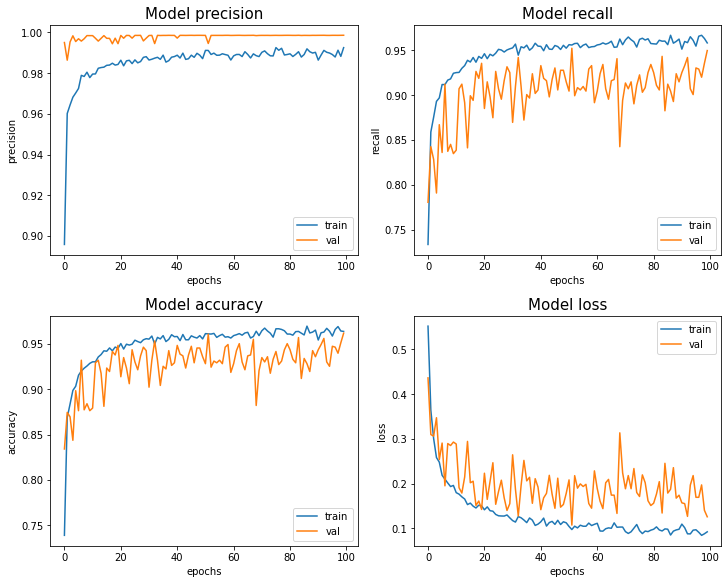

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [36]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

13/13 [==============================] - 6s 427ms/step - loss: 0.4829 - accuracy: 0.8830 - precision: 0.8514 - recall: 0.9846
Loss: 0.4829252064228058,
Accuracy: 0.8830128312110901,
Precision: 0.8514412641525269,
Recall: 0.9846153855323792


---

# IncenptionV3 - Flatten

In [37]:
InceptionV3_MODEL = applications.InceptionV3(input_shape = IMG_SIZE_CH, 
                           include_top=False, 
                           weights='imagenet') 
# 사전훈련된 가중치를 이용해 기본 모델을 인스턴스화

InceptionV3_MODEL.trainable=False                   # 기본 모델을 동결

model = Sequential()
model.add(InceptionV3_MODEL)
model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
model.add(Dense(64, activation = 'relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

history = model.fit(
        train_generator,
        steps_per_epoch=4695 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

---

# InceptionV3 - GlobalAveragePooling2D

In [38]:
model = Sequential()
model.add(InceptionV3_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.7))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

In [39]:
history = model.fit(
        train_generator,
        steps_per_epoch=4173 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weight)

Epoch 1/100
83/83 [==============================] - 101s 1s/step - loss: 0.5017 - accuracy: 0.7651 - precision: 0.9060 - recall: 0.7613 - val_loss: 0.3870 - val_accuracy: 0.8341 - val_precision: 0.9886 - val_recall: 0.7858
Epoch 2/100
83/83 [==============================] - 93s 1s/step - loss: 0.2719 - accuracy: 0.8772 - precision: 0.9622 - recall: 0.8689 - val_loss: 0.2998 - val_accuracy: 0.8725 - val_precision: 0.9864 - val_recall: 0.8400
Epoch 3/100
83/83 [==============================] - 94s 1s/step - loss: 0.2447 - accuracy: 0.8963 - precision: 0.9678 - recall: 0.8899 - val_loss: 0.3157 - val_accuracy: 0.8571 - val_precision: 0.9891 - val_recall: 0.8168
Epoch 4/100
83/83 [==============================] - 92s 1s/step - loss: 0.1986 - accuracy: 0.9198 - precision: 0.9804 - recall: 0.9112 - val_loss: 0.2029 - val_accuracy: 0.9137 - val_precision: 0.9858 - val_recall: 0.8968
Epoch 5/100
83/83 [==============================] - 93s 1s/step - loss: 0.2084 - accuracy: 0.9197 - precis

Epoch 39/100
83/83 [==============================] - 92s 1s/step - loss: 0.1265 - accuracy: 0.9467 - precision: 0.9856 - recall: 0.9428 - val_loss: 0.1546 - val_accuracy: 0.9434 - val_precision: 0.9877 - val_recall: 0.9355
Epoch 40/100
83/83 [==============================] - 93s 1s/step - loss: 0.1391 - accuracy: 0.9413 - precision: 0.9813 - recall: 0.9386 - val_loss: 0.1681 - val_accuracy: 0.9319 - val_precision: 0.9916 - val_recall: 0.9161
Epoch 41/100
83/83 [==============================] - 92s 1s/step - loss: 0.1291 - accuracy: 0.9534 - precision: 0.9848 - recall: 0.9526 - val_loss: 0.1700 - val_accuracy: 0.9367 - val_precision: 0.9930 - val_recall: 0.9213
Epoch 42/100
83/83 [==============================] - 93s 1s/step - loss: 0.1442 - accuracy: 0.9395 - precision: 0.9837 - recall: 0.9345 - val_loss: 0.1685 - val_accuracy: 0.9377 - val_precision: 0.9931 - val_recall: 0.9226
Epoch 43/100
83/83 [==============================] - 93s 1s/step - loss: 0.1075 - accuracy: 0.9528 - pr

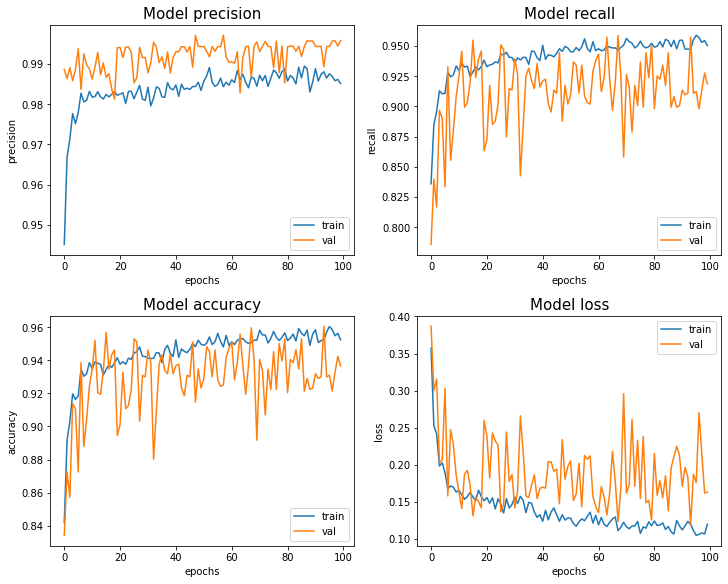

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

13/13 [==============================] - 6s 412ms/step - loss: 0.3817 - accuracy: 0.8734 - precision: 0.8510 - recall: 0.9667
Loss: 0.3817204535007477,
Accuracy: 0.8733974099159241,
Precision: 0.8510158061981201,
Recall: 0.9666666388511658


---

# DenseNet201 - Flatten

In [2]:
DenseNet201_MODEL = applications.DenseNet201(input_shape = IMG_SIZE_CH, 
                           include_top=False, 
                           weights='imagenet') 
# 사전훈련된 가중치를 이용해 기본 모델을 인스턴스화

DenseNet201_MODEL.trainable=False                   # 기본 모델을 동결

74842112/74836368 [==============================] - 1s 0us/step


model = Sequential()
model.add(DenseNet201_MODEL)
model.add(Flatten())  
model.add(Dense(64, activation = 'relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

history = model.fit(
        train_generator,
        steps_per_epoch=4695 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# DenseNet201 - GlobalAveragePooling2D

In [3]:
model = Sequential()
model.add(DenseNet201_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.7))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

In [4]:
history = model.fit(
        train_generator,
        steps_per_epoch=4173 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weight)

Epoch 1/100
83/83 [==============================] - 244s 2s/step - loss: 0.4007 - accuracy: 0.8077 - precision: 0.9231 - recall: 0.8089 - val_loss: 0.1498 - val_accuracy: 0.9463 - val_precision: 0.9826 - val_recall: 0.9445
Epoch 2/100
83/83 [==============================] - 110s 1s/step - loss: 0.1800 - accuracy: 0.9269 - precision: 0.9743 - recall: 0.9257 - val_loss: 0.1182 - val_accuracy: 0.9607 - val_precision: 0.9893 - val_recall: 0.9574
Epoch 3/100
83/83 [==============================] - 108s 1s/step - loss: 0.1537 - accuracy: 0.9460 - precision: 0.9854 - recall: 0.9414 - val_loss: 0.1664 - val_accuracy: 0.9281 - val_precision: 0.9972 - val_recall: 0.9058
Epoch 4/100
83/83 [==============================] - 106s 1s/step - loss: 0.1245 - accuracy: 0.9513 - precision: 0.9884 - recall: 0.9458 - val_loss: 0.1007 - val_accuracy: 0.9645 - val_precision: 0.9946 - val_recall: 0.9574
Epoch 5/100
83/83 [==============================] - 108s 1s/step - loss: 0.1183 - accuracy: 0.9522 - pr

83/83 [==============================] - 116s 1s/step - loss: 0.0489 - accuracy: 0.9801 - precision: 0.9949 - recall: 0.9785 - val_loss: 0.1755 - val_accuracy: 0.9367 - val_precision: 0.9986 - val_recall: 0.9161
Epoch 74/100
83/83 [==============================] - 116s 1s/step - loss: 0.0660 - accuracy: 0.9751 - precision: 0.9946 - recall: 0.9717 - val_loss: 0.0661 - val_accuracy: 0.9799 - val_precision: 0.9935 - val_recall: 0.9794
Epoch 75/100
83/83 [==============================] - 116s 1s/step - loss: 0.0520 - accuracy: 0.9788 - precision: 0.9957 - recall: 0.9760 - val_loss: 0.1210 - val_accuracy: 0.9616 - val_precision: 0.9973 - val_recall: 0.9510
Epoch 76/100
83/83 [==============================] - 116s 1s/step - loss: 0.0559 - accuracy: 0.9778 - precision: 0.9953 - recall: 0.9750 - val_loss: 0.0828 - val_accuracy: 0.9703 - val_precision: 0.9934 - val_recall: 0.9665
Epoch 77/100
83/83 [==============================] - 115s 1s/step - loss: 0.0470 - accuracy: 0.9816 - precision:

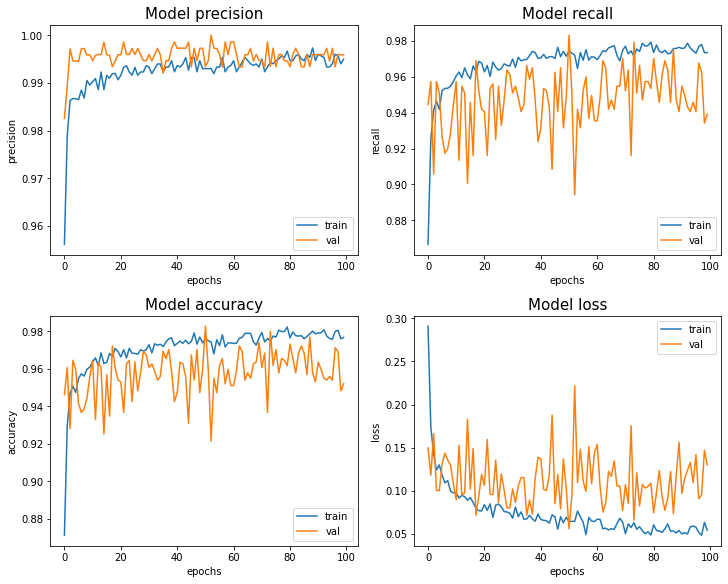

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [6]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

13/13 [==============================] - 38s 3s/step - loss: 0.4374 - accuracy: 0.8974 - precision: 0.8721 - recall: 0.9795
Loss: 0.43739885091781616,
Accuracy: 0.8974359035491943,
Precision: 0.8721461296081543,
Recall: 0.9794871807098389


---

# ResNet152 - GlobalAveragePooling2D

In [11]:
ResNet152_MODEL = applications.ResNet152(input_shape = IMG_SIZE_CH, 
                           include_top=False, 
                           weights='imagenet') 
# 사전훈련된 가중치를 이용해 기본 모델을 인스턴스화

ResNet152_MODEL.trainable=False                   # 기본 모델을 동결

In [12]:
model = Sequential()
model.add(ResNet152_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.7))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

In [15]:
history = model.fit(
        train_generator,
        steps_per_epoch=4173 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weight)

Epoch 1/100
83/83 [==============================] - 117s 1s/step - loss: 0.3475 - accuracy: 0.8157 - precision: 0.9622 - recall: 0.7822 - val_loss: 0.3721 - val_accuracy: 0.8265 - val_precision: 0.9760 - val_recall: 0.7858
Epoch 2/100
83/83 [==============================] - 114s 1s/step - loss: 0.3749 - accuracy: 0.7970 - precision: 0.9550 - recall: 0.7623 - val_loss: 0.3689 - val_accuracy: 0.8159 - val_precision: 0.9787 - val_recall: 0.7690
Epoch 3/100
83/83 [==============================] - 115s 1s/step - loss: 0.3709 - accuracy: 0.7977 - precision: 0.9543 - recall: 0.7641 - val_loss: 0.3799 - val_accuracy: 0.8025 - val_precision: 0.9847 - val_recall: 0.7458
Epoch 4/100
83/83 [==============================] - 115s 1s/step - loss: 0.3629 - accuracy: 0.8052 - precision: 0.9578 - recall: 0.7717 - val_loss: 0.3544 - val_accuracy: 0.8313 - val_precision: 0.9762 - val_recall: 0.7923
Epoch 5/100
83/83 [==============================] - 114s 1s/step - loss: 0.3562 - accuracy: 0.8069 - pr

83/83 [==============================] - 113s 1s/step - loss: 0.3461 - accuracy: 0.8118 - precision: 0.9632 - recall: 0.7767 - val_loss: 0.3069 - val_accuracy: 0.8360 - val_precision: 0.9824 - val_recall: 0.7935
Epoch 38/100
83/83 [==============================] - 115s 1s/step - loss: 0.3572 - accuracy: 0.8162 - precision: 0.9661 - recall: 0.7801 - val_loss: 0.3190 - val_accuracy: 0.8255 - val_precision: 0.9853 - val_recall: 0.7768
Epoch 39/100
83/83 [==============================] - 113s 1s/step - loss: 0.3546 - accuracy: 0.8169 - precision: 0.9627 - recall: 0.7837 - val_loss: 0.3234 - val_accuracy: 0.8313 - val_precision: 0.9807 - val_recall: 0.7884
Epoch 41/100
83/83 [==============================] - 115s 1s/step - loss: 0.3760 - accuracy: 0.8140 - precision: 0.9545 - recall: 0.7871 - val_loss: 0.3714 - val_accuracy: 0.8092 - val_precision: 0.9966 - val_recall: 0.7458
Epoch 42/100
83/83 [==============================] - 114s 1s/step - loss: 0.3449 - accuracy: 0.8164 - precision:

83/83 [==============================] - 115s 1s/step - loss: 0.3247 - accuracy: 0.8171 - precision: 0.9657 - recall: 0.7816 - val_loss: 0.3941 - val_accuracy: 0.8035 - val_precision: 0.9983 - val_recall: 0.7368
Epoch 75/100
83/83 [==============================] - 116s 1s/step - loss: 0.3289 - accuracy: 0.8152 - precision: 0.9645 - recall: 0.7800 - val_loss: 0.2965 - val_accuracy: 0.8495 - val_precision: 0.9920 - val_recall: 0.8039
Epoch 76/100
83/83 [==============================] - 115s 1s/step - loss: 0.3455 - accuracy: 0.8193 - precision: 0.9670 - recall: 0.7836 - val_loss: 0.3837 - val_accuracy: 0.8140 - val_precision: 0.9983 - val_recall: 0.7510
Epoch 77/100
83/83 [==============================] - 116s 1s/step - loss: 0.3232 - accuracy: 0.8193 - precision: 0.9678 - recall: 0.7833 - val_loss: 0.3401 - val_accuracy: 0.8313 - val_precision: 0.9967 - val_recall: 0.7755
Epoch 78/100
83/83 [==============================] - 117s 1s/step - loss: 0.3184 - accuracy: 0.8246 - precision:

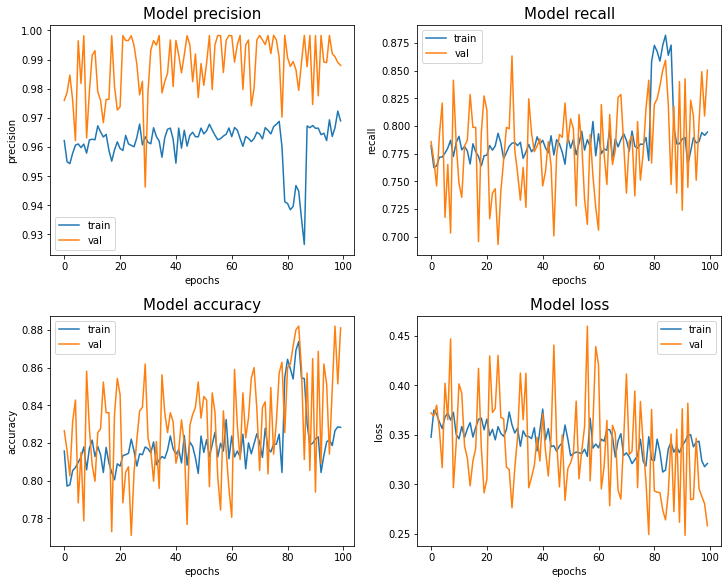

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [17]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

13/13 [==============================] - 17s 1s/step - loss: 0.4774 - accuracy: 0.7756 - precision: 0.7765 - recall: 0.9000
Loss: 0.4774395525455475,
Accuracy: 0.7756410241127014,
Precision: 0.7765486836433411,
Recall: 0.8999999761581421


---

# MobileNetV2 - GlobalAveragePooling2D

In [18]:
MobileNetV2_MODEL = applications.MobileNetV2(input_shape = IMG_SIZE_CH, 
                           include_top=False, 
                           weights='imagenet') 
# 사전훈련된 가중치를 이용해 기본 모델을 인스턴스화

MobileNetV2_MODEL.trainable=False                   # 기본 모델을 동결

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
model = Sequential()
model.add(MobileNetV2_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.7))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

In [20]:
history = model.fit(
        train_generator,
        steps_per_epoch=4173 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weight)

Epoch 1/100
83/83 [==============================] - 132s 1s/step - loss: 0.4301 - accuracy: 0.7955 - precision: 0.9151 - recall: 0.7953 - val_loss: 0.1785 - val_accuracy: 0.9252 - val_precision: 0.9943 - val_recall: 0.9045
Epoch 2/100
83/83 [==============================] - 109s 1s/step - loss: 0.1555 - accuracy: 0.9367 - precision: 0.9857 - recall: 0.9280 - val_loss: 0.2191 - val_accuracy: 0.9051 - val_precision: 0.9971 - val_recall: 0.8748
Epoch 3/100
83/83 [==============================] - 108s 1s/step - loss: 0.1429 - accuracy: 0.9420 - precision: 0.9834 - recall: 0.9378 - val_loss: 0.2040 - val_accuracy: 0.9128 - val_precision: 0.9985 - val_recall: 0.8839
Epoch 4/100
83/83 [==============================] - 107s 1s/step - loss: 0.1139 - accuracy: 0.9528 - precision: 0.9884 - recall: 0.9486 - val_loss: 0.1448 - val_accuracy: 0.9444 - val_precision: 0.9945 - val_recall: 0.9303
Epoch 5/100
83/83 [==============================] - 108s 1s/step - loss: 0.1272 - accuracy: 0.9453 - pr

83/83 [==============================] - 107s 1s/step - loss: 0.0622 - accuracy: 0.9771 - precision: 0.9930 - recall: 0.9760 - val_loss: 0.1112 - val_accuracy: 0.9578 - val_precision: 0.9946 - val_recall: 0.9484
Epoch 38/100
83/83 [==============================] - 106s 1s/step - loss: 0.0834 - accuracy: 0.9694 - precision: 0.9885 - recall: 0.9692 - val_loss: 0.1140 - val_accuracy: 0.9588 - val_precision: 0.9959 - val_recall: 0.9484
Epoch 39/100
83/83 [==============================] - 106s 1s/step - loss: 0.0753 - accuracy: 0.9757 - precision: 0.9949 - recall: 0.9721 - val_loss: 0.2220 - val_accuracy: 0.9204 - val_precision: 1.0000 - val_recall: 0.8929
Epoch 40/100
83/83 [==============================] - 108s 1s/step - loss: 0.0691 - accuracy: 0.9697 - precision: 0.9933 - recall: 0.9654 - val_loss: 0.1413 - val_accuracy: 0.9482 - val_precision: 0.9972 - val_recall: 0.9329
Epoch 41/100
83/83 [==============================] - 108s 1s/step - loss: 0.0802 - accuracy: 0.9731 - precision:

83/83 [==============================] - 106s 1s/step - loss: 0.0595 - accuracy: 0.9746 - precision: 0.9935 - recall: 0.9722 - val_loss: 0.1552 - val_accuracy: 0.9521 - val_precision: 0.9973 - val_recall: 0.9381
Epoch 74/100
83/83 [==============================] - 106s 1s/step - loss: 0.0530 - accuracy: 0.9743 - precision: 0.9951 - recall: 0.9695 - val_loss: 0.2657 - val_accuracy: 0.9070 - val_precision: 0.9985 - val_recall: 0.8761
Epoch 75/100
83/83 [==============================] - 107s 1s/step - loss: 0.0609 - accuracy: 0.9725 - precision: 0.9924 - recall: 0.9707 - val_loss: 0.1747 - val_accuracy: 0.9386 - val_precision: 0.9958 - val_recall: 0.9213
Epoch 76/100
83/83 [==============================] - 106s 1s/step - loss: 0.0520 - accuracy: 0.9781 - precision: 0.9943 - recall: 0.9760 - val_loss: 0.2133 - val_accuracy: 0.9338 - val_precision: 0.9986 - val_recall: 0.9123
Epoch 77/100
83/83 [==============================] - 106s 1s/step - loss: 0.0611 - accuracy: 0.9742 - precision:

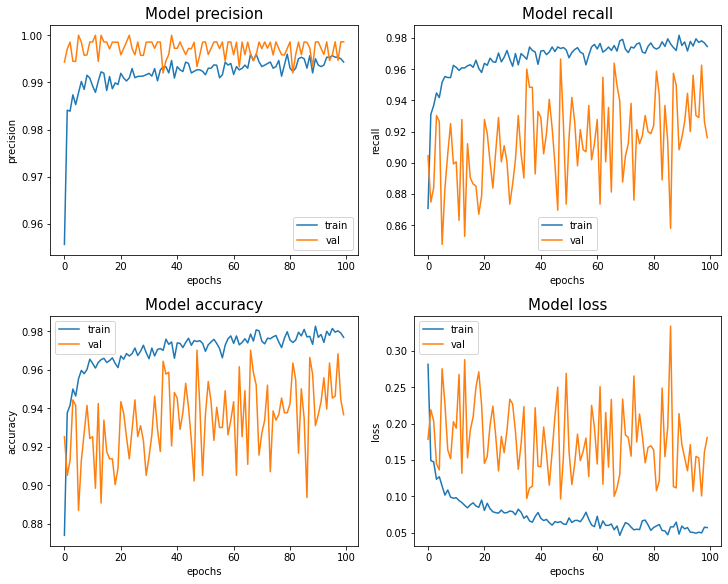

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

13/13 [==============================] - 13s 1s/step - loss: 0.3602 - accuracy: 0.9071 - precision: 0.8915 - recall: 0.9692
Loss: 0.36018356680870056,
Accuracy: 0.9070512652397156,
Precision: 0.8915094137191772,
Recall: 0.9692307710647583


---

---

---

---

---

---

# Agumentation

In [66]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import Precision
from keras.metrics import Recall
from keras import applications
from keras.layers import GlobalAveragePooling2D

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SIZE_CH = (224, 224, 3)
EPOCHS = 10

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
train_datagen = ImageDataGenerator(rescale = 1./255,          # 픽셀값 스케일 조정
                                   validation_split = 0.2,
                                   rotation_range = 5,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.05,
                                   horizontal_flip = True,
                                   brightness_range = (0.95,1.05),
                                   fill_mode = 'nearest')    # augumentation은 좌우대칭만 적용


# 검증 및 테스트 이미지는 augmentation을 적용하지 않습니다. 모델 성능을 평가할 때에는 이미지 원본을 사용합니다.
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/train',  # this is the target directory
        target_size=IMG_SIZE,  # 모든 이미지의 크기가 IMG_SIZE로 조정됩니다.
        batch_size=BATCH_SIZE,
        class_mode='binary',  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.
        subset ='training')

val_generator = val_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


---

In [18]:
model = Sequential()
model.add(VGG16_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])
history = model.fit(
        train_generator,
        steps_per_epoch= 2930 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

Epoch 1/10
91/91 [==============================] - 68s 738ms/step - loss: 0.5377 - accuracy: 0.7476 - precision: 0.7663 - recall: 0.9603 - val_loss: 0.3596 - val_accuracy: 0.8369 - val_precision: 0.8495 - val_recall: 0.9483
Epoch 2/10
91/91 [==============================] - 66s 720ms/step - loss: 0.3710 - accuracy: 0.8385 - precision: 0.8511 - recall: 0.9454 - val_loss: 0.2741 - val_accuracy: 0.8906 - val_precision: 0.9412 - val_recall: 0.9096
Epoch 3/10
91/91 [==============================] - 66s 719ms/step - loss: 0.2900 - accuracy: 0.8921 - precision: 0.9159 - recall: 0.9421 - val_loss: 0.2378 - val_accuracy: 0.9021 - val_precision: 0.9615 - val_recall: 0.9044
Epoch 4/10
91/91 [==============================] - 65s 712ms/step - loss: 0.2421 - accuracy: 0.9157 - precision: 0.9354 - recall: 0.9519 - val_loss: 0.2076 - val_accuracy: 0.9136 - val_precision: 0.9572 - val_recall: 0.9251
Epoch 5/10
91/91 [==============================] - 66s 722ms/step - loss: 0.2357 - accuracy: 0.9159

In [19]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 6s 300ms/step - loss: 0.2909 - accuracy: 0.9006 - precision: 0.8814 - recall: 0.9718
Loss: 0.2909281849861145,
Accuracy: 0.9006410241127014,
Precision: 0.8813953399658203,
Recall: 0.971794843673706


---

In [20]:
model = Sequential()
model.add(InceptionV3_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])
history = model.fit(
        train_generator,
        steps_per_epoch= 2930 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

Epoch 1/10
91/91 [==============================] - 72s 737ms/step - loss: 0.4092 - accuracy: 0.8192 - precision: 0.8642 - recall: 0.9020 - val_loss: 0.2486 - val_accuracy: 0.8925 - val_precision: 0.9584 - val_recall: 0.8941
Epoch 2/10
91/91 [==============================] - 65s 716ms/step - loss: 0.2339 - accuracy: 0.9132 - precision: 0.9376 - recall: 0.9469 - val_loss: 0.1992 - val_accuracy: 0.9251 - val_precision: 0.9485 - val_recall: 0.9509
Epoch 3/10
91/91 [==============================] - 66s 721ms/step - loss: 0.1962 - accuracy: 0.9242 - precision: 0.9473 - recall: 0.9496 - val_loss: 0.1912 - val_accuracy: 0.9290 - val_precision: 0.9605 - val_recall: 0.9432
Epoch 4/10
91/91 [==============================] - 66s 722ms/step - loss: 0.1782 - accuracy: 0.9294 - precision: 0.9508 - recall: 0.9526 - val_loss: 0.1772 - val_accuracy: 0.9386 - val_precision: 0.9610 - val_recall: 0.9561
Epoch 5/10
91/91 [==============================] - 64s 706ms/step - loss: 0.1838 - accuracy: 0.9262

In [21]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 23s 1s/step - loss: 0.4794 - accuracy: 0.8349 - precision: 0.8060 - recall: 0.9692
Loss: 0.47937658429145813,
Accuracy: 0.8349359035491943,
Precision: 0.8059701323509216,
Recall: 0.9692307710647583


---

# DenseNet201

In [22]:
model = Sequential()
model.add(DenseNet201_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
model.add(Dense(64, activation = 'relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])
history = model.fit(
        train_generator,
        steps_per_epoch= 2930 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

Epoch 1/10
91/91 [==============================] - 222s 2s/step - loss: 0.3713 - accuracy: 0.8361 - precision: 0.8749 - recall: 0.9105 - val_loss: 0.1644 - val_accuracy: 0.9367 - val_precision: 0.9836 - val_recall: 0.9302
Epoch 2/10
91/91 [==============================] - 68s 747ms/step - loss: 0.1660 - accuracy: 0.9364 - precision: 0.9589 - recall: 0.9560 - val_loss: 0.1281 - val_accuracy: 0.9559 - val_precision: 0.9764 - val_recall: 0.9638
Epoch 3/10
91/91 [==============================] - 67s 730ms/step - loss: 0.1509 - accuracy: 0.9366 - precision: 0.9526 - recall: 0.9616 - val_loss: 0.1221 - val_accuracy: 0.9501 - val_precision: 0.9892 - val_recall: 0.9432
Epoch 4/10
91/91 [==============================] - 67s 729ms/step - loss: 0.1218 - accuracy: 0.9479 - precision: 0.9661 - recall: 0.9639 - val_loss: 0.1025 - val_accuracy: 0.9616 - val_precision: 0.9842 - val_recall: 0.9638
Epoch 5/10
91/91 [==============================] - 66s 722ms/step - loss: 0.1048 - accuracy: 0.9651 -

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 54s 3s/step - loss: 0.5992 - accuracy: 0.8029 - precision: 0.7633 - recall: 0.9923
Loss: 0.5992278456687927,
Accuracy: 0.8028846383094788,
Precision: 0.7633135914802551,
Recall: 0.9923076629638672


---

In [24]:
model = Sequential()
model.add(ResNet152_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
model.add(Dense(64, activation = 'relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])
history = model.fit(
        train_generator,
        steps_per_epoch= 2930 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

Epoch 1/10
91/91 [==============================] - 109s 1s/step - loss: 0.5979 - accuracy: 0.7308 - precision: 0.7527 - recall: 0.9528 - val_loss: 0.5605 - val_accuracy: 0.7428 - val_precision: 0.7428 - val_recall: 1.0000
Epoch 2/10
91/91 [==============================] - 71s 778ms/step - loss: 0.5810 - accuracy: 0.7334 - precision: 0.7337 - recall: 0.9991 - val_loss: 0.5435 - val_accuracy: 0.7428 - val_precision: 0.7428 - val_recall: 1.0000
Epoch 3/10
91/91 [==============================] - 71s 771ms/step - loss: 0.5447 - accuracy: 0.7557 - precision: 0.7557 - recall: 1.0000 - val_loss: 0.5251 - val_accuracy: 0.7428 - val_precision: 0.7428 - val_recall: 1.0000
Epoch 4/10
91/91 [==============================] - 71s 771ms/step - loss: 0.5283 - accuracy: 0.7442 - precision: 0.7442 - recall: 1.0000 - val_loss: 0.5049 - val_accuracy: 0.7428 - val_precision: 0.7428 - val_recall: 1.0000
Epoch 5/10
91/91 [==============================] - 71s 775ms/step - loss: 0.5158 - accuracy: 0.7292 -

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 19s 944ms/step - loss: 0.5541 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.5540841817855835,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


---

# MobileNetV2

In [26]:
model = Sequential()
model.add(MobileNetV2_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
model.add(Dense(64, activation = 'relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

In [27]:
history = model.fit(
        train_generator,
        steps_per_epoch= 2930 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

Epoch 1/10
91/91 [==============================] - 96s 932ms/step - loss: 0.3655 - accuracy: 0.8317 - precision: 0.8664 - recall: 0.9186 - val_loss: 0.1433 - val_accuracy: 0.9482 - val_precision: 0.9891 - val_recall: 0.9406
Epoch 2/10
91/91 [==============================] - 65s 719ms/step - loss: 0.1543 - accuracy: 0.9379 - precision: 0.9563 - recall: 0.9594 - val_loss: 0.1155 - val_accuracy: 0.9616 - val_precision: 0.9842 - val_recall: 0.9638
Epoch 3/10
91/91 [==============================] - 65s 709ms/step - loss: 0.1447 - accuracy: 0.9412 - precision: 0.9541 - recall: 0.9664 - val_loss: 0.1334 - val_accuracy: 0.9443 - val_precision: 0.9918 - val_recall: 0.9328
Epoch 4/10
91/91 [==============================] - 65s 713ms/step - loss: 0.1144 - accuracy: 0.9616 - precision: 0.9761 - recall: 0.9718 - val_loss: 0.1232 - val_accuracy: 0.9482 - val_precision: 0.9891 - val_recall: 0.9406
Epoch 5/10
91/91 [==============================] - 64s 708ms/step - loss: 0.1083 - accuracy: 0.9542

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 15s 763ms/step - loss: 0.4449 - accuracy: 0.8590 - precision: 0.8213 - recall: 0.9897
Loss: 0.44490358233451843,
Accuracy: 0.8589743375778198,
Precision: 0.8212766051292419,
Recall: 0.9897435903549194


---

In [59]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import Precision
from keras.metrics import Recall
from keras import applications
from keras.layers import GlobalAveragePooling2D

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
BATCH_SIZE = 50
IMG_SIZE = (224, 224)
IMG_SIZE_CH = (224, 224, 3)
EPOCHS = 100

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
train_datagen = ImageDataGenerator(rescale = 1./255,          # 픽셀값 스케일 조정
                                   validation_split = 0.2,
                                   rotation_range = 5,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.05,
                                   horizontal_flip = True,
                                   brightness_range = (0.95,1.05),
                                   fill_mode = 'nearest')    # augumentation은 좌우대칭만 적용


# 검증 및 테스트 이미지는 augmentation을 적용하지 않습니다. 모델 성능을 평가할 때에는 이미지 원본을 사용합니다.
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/train',  # this is the target directory
        target_size=IMG_SIZE,  # 모든 이미지의 크기가 IMG_SIZE로 조정됩니다.
        batch_size=BATCH_SIZE,
        class_mode='binary',  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.
        subset ='training')

val_generator = val_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 4173 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


---

In [60]:
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=IMG_SIZE_CH, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import Precision
from keras.metrics import Recall

model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])
history = model.fit(
        train_generator,
        steps_per_epoch= 2930 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

Epoch 1/100
58/58 [==============================] - 66s 1s/step - loss: 0.6566 - accuracy: 0.6968 - precision: 0.7447 - recall: 0.8931 - val_loss: 0.3498 - val_accuracy: 0.8522 - val_precision: 0.8995 - val_recall: 0.9018
Epoch 2/100
58/58 [==============================] - 64s 1s/step - loss: 0.3819 - accuracy: 0.8014 - precision: 0.8102 - recall: 0.9551 - val_loss: 0.4539 - val_accuracy: 0.8484 - val_precision: 0.9611 - val_recall: 0.8295
Epoch 3/100
58/58 [==============================] - 65s 1s/step - loss: 0.3243 - accuracy: 0.8645 - precision: 0.8886 - recall: 0.9368 - val_loss: 0.2672 - val_accuracy: 0.8983 - val_precision: 0.9639 - val_recall: 0.8966
Epoch 4/100
58/58 [==============================] - 65s 1s/step - loss: 0.2734 - accuracy: 0.8937 - precision: 0.9152 - recall: 0.9469 - val_loss: 0.2245 - val_accuracy: 0.9002 - val_precision: 0.9095 - val_recall: 0.9612
Epoch 5/100
58/58 [==============================] - 63s 1s/step - loss: 0.2529 - accuracy: 0.8972 - precisi

Epoch 38/100
58/58 [==============================] - 63s 1s/step - loss: 0.1532 - accuracy: 0.9393 - precision: 0.9732 - recall: 0.9459 - val_loss: 0.1166 - val_accuracy: 0.9520 - val_precision: 0.9945 - val_recall: 0.9406
Epoch 39/100
58/58 [==============================] - 63s 1s/step - loss: 0.1372 - accuracy: 0.9589 - precision: 0.9783 - recall: 0.9657 - val_loss: 0.1600 - val_accuracy: 0.9290 - val_precision: 0.9972 - val_recall: 0.9070
Epoch 40/100
58/58 [==============================] - 62s 1s/step - loss: 0.1219 - accuracy: 0.9546 - precision: 0.9798 - recall: 0.9585 - val_loss: 0.1214 - val_accuracy: 0.9520 - val_precision: 0.9945 - val_recall: 0.9406
Epoch 41/100
58/58 [==============================] - 63s 1s/step - loss: 0.1276 - accuracy: 0.9563 - precision: 0.9799 - recall: 0.9608 - val_loss: 0.1195 - val_accuracy: 0.9501 - val_precision: 0.9892 - val_recall: 0.9432
Epoch 42/100
58/58 [==============================] - 63s 1s/step - loss: 0.1101 - accuracy: 0.9610 - pr

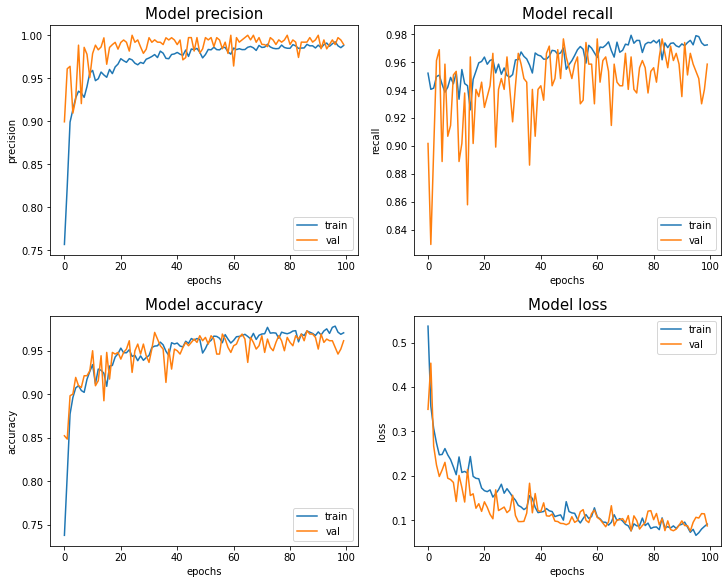

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [62]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

13/13 [==============================] - 6s 429ms/step - loss: 1.5184 - accuracy: 0.7724 - precision: 0.7366 - recall: 0.9897
Loss: 1.5183789730072021,
Accuracy: 0.7724359035491943,
Precision: 0.7366412281990051,
Recall: 0.9897435903549194


---

In [63]:
model = Sequential()
model.add(VGG16_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])
history = model.fit(
        train_generator,
        steps_per_epoch= 2930 // BATCH_SIZE,
        validation_data=val_generator,
        epochs=EPOCHS)

Epoch 1/100
58/58 [==============================] - 67s 1s/step - loss: 0.6773 - accuracy: 0.6544 - precision: 0.7344 - recall: 0.8333 - val_loss: 0.4318 - val_accuracy: 0.7505 - val_precision: 0.7495 - val_recall: 0.9974
Epoch 2/100
58/58 [==============================] - 65s 1s/step - loss: 0.4201 - accuracy: 0.7950 - precision: 0.7921 - recall: 0.9801 - val_loss: 0.3241 - val_accuracy: 0.8752 - val_precision: 0.9107 - val_recall: 0.9225
Epoch 3/100
58/58 [==============================] - 64s 1s/step - loss: 0.3327 - accuracy: 0.8596 - precision: 0.8713 - recall: 0.9514 - val_loss: 0.2730 - val_accuracy: 0.8964 - val_precision: 0.9512 - val_recall: 0.9070
Epoch 4/100
58/58 [==============================] - 65s 1s/step - loss: 0.2920 - accuracy: 0.8818 - precision: 0.8970 - recall: 0.9478 - val_loss: 0.2351 - val_accuracy: 0.9002 - val_precision: 0.9328 - val_recall: 0.9328
Epoch 5/100
58/58 [==============================] - 65s 1s/step - loss: 0.2631 - accuracy: 0.8959 - precisi

Epoch 38/100
58/58 [==============================] - 65s 1s/step - loss: 0.1190 - accuracy: 0.9602 - precision: 0.9757 - recall: 0.9708 - val_loss: 0.1469 - val_accuracy: 0.9386 - val_precision: 0.9944 - val_recall: 0.9225
Epoch 39/100
58/58 [==============================] - 65s 1s/step - loss: 0.1426 - accuracy: 0.9489 - precision: 0.9721 - recall: 0.9600 - val_loss: 0.1790 - val_accuracy: 0.9309 - val_precision: 0.9972 - val_recall: 0.9096
Epoch 40/100
58/58 [==============================] - 64s 1s/step - loss: 0.1241 - accuracy: 0.9552 - precision: 0.9731 - recall: 0.9672 - val_loss: 0.1501 - val_accuracy: 0.9386 - val_precision: 0.9944 - val_recall: 0.9225
Epoch 41/100
58/58 [==============================] - 64s 1s/step - loss: 0.1106 - accuracy: 0.9598 - precision: 0.9746 - recall: 0.9712 - val_loss: 0.1070 - val_accuracy: 0.9597 - val_precision: 0.9893 - val_recall: 0.9561
Epoch 42/100
58/58 [==============================] - 65s 1s/step - loss: 0.1134 - accuracy: 0.9609 - pr

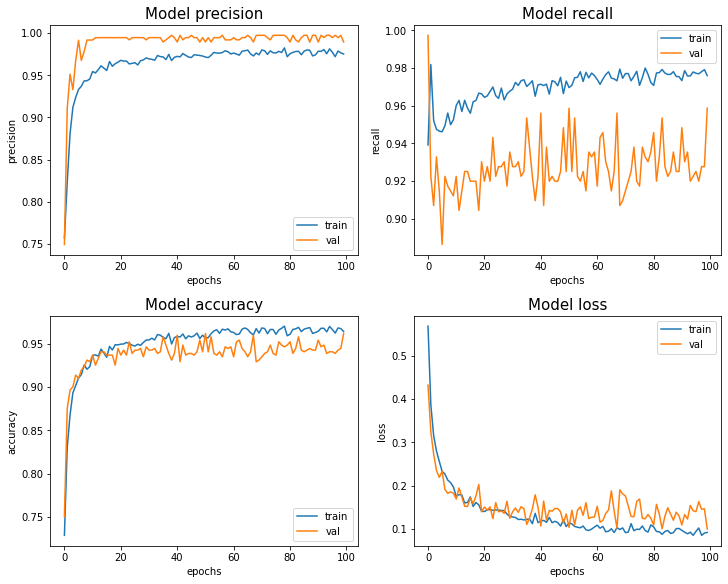

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [65]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

13/13 [==============================] - 17s 1s/step - loss: 0.4944 - accuracy: 0.8574 - precision: 0.8195 - recall: 0.9897
Loss: 0.4944394826889038,
Accuracy: 0.8573718070983887,
Precision: 0.8195329308509827,
Recall: 0.9897435903549194
